In [1]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact,pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gp
import plotly.express as px
import shap
from joblib import dump
from joblib import load
%config IPCompleter.greedy=True

In [2]:
plt.rcParams['figure.dpi'] = 72
df1 = pd.read_csv('vehicles_trimmed1.csv')
df2 = df1
df2['price'] = df2['price'].replace(0,np.NaN)
df2 = df2.dropna(subset=['price'])
df2 = df2[(df2['price'] >= np.percentile(df2['price'], 0.05)) &
          (df2['price'] <= np.percentile(df2['price'], 99.95))]
train_orig, test = train_test_split(df2.drop(columns=['county','Unnamed: 0']) , test_size = 0.1, train_size = 0.9)
train, val = train_test_split(train_orig, train_size = 0.9, test_size = 0.1)
train

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,image_url,state,lat,long
422539,7047704062,eugene,43900.0,2016.0,gmc,sierra 2500 slt diesel lifte,NaN,NaN,diesel,85172.0,clean,automatic,4wd,NaN,pickup,silver,https://images.craigslist.org/00E0E_2lkDSQcggT...,or,45.5154,-122.4200
91660,7049746214,los angeles,9195.0,2014.0,kia,forte,NaN,NaN,gas,96408.0,clean,automatic,NaN,NaN,sedan,blue,https://images.craigslist.org/00A0A_83Ua87qnLZ...,ca,33.9962,-117.9170
60604,7042188902,anchorage / mat-su,27990.0,2018.0,toyota,highlander,NaN,NaN,gas,36639.0,clean,automatic,4wd,NaN,wagon,blue,https://images.craigslist.org/00s0s_esufCQ7lxr...,ak,61.1867,-149.9150
485540,7042313250,corpus christi,20910.0,2016.0,toyota,tundra,NaN,8 cylinders,gas,110999.0,clean,automatic,rwd,full-size,pickup,silver,https://images.craigslist.org/00R0R_dj1NDg72Yp...,tx,27.7036,-97.3450
425631,7045414285,medford-ashland,34995.0,2014.0,ford,f-250 super duty xlt 4x4 4d,NaN,NaN,diesel,72011.0,clean,automatic,NaN,NaN,NaN,NaN,https://images.craigslist.org/00k0k_70BZbxzZUh...,or,44.6296,-123.0560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189268,7040591385,treasure coast,15450.0,2017.0,ford,fusion,excellent,4 cylinders,gas,25809.0,clean,automatic,fwd,full-size,sedan,red,https://images.craigslist.org/00p0p_g5Tk2cVf1w...,fl,27.3655,-80.3263
216088,7033801218,"quad cities, IA/IL",2200.0,2005.0,ford,f-150,fair,8 cylinders,gas,NaN,clean,other,4wd,NaN,pickup,NaN,https://images.craigslist.org/00X0X_jzUQJJoQ1Z...,il,41.5007,-90.4126
389925,7034393653,north dakota,10400.0,2019.0,NaN,DELCO TRAILERS DELCO TRAILERS,NaN,NaN,gas,NaN,clean,NaN,NaN,NaN,other,black,https://images.craigslist.org/00D0D_dX3zUNrBVE...,nd,40.3744,-104.6940
405563,7035321025,mansfield,15995.0,2018.0,chevrolet,cruze lt,like new,4 cylinders,gas,7640.0,clean,automatic,fwd,compact,sedan,red,https://images.craigslist.org/01010_7F0BLZ8Fht...,oh,40.8125,-82.9496


In [3]:
## Final model for app usage

target = 'price'
features1 = ['year', 'manufacturer', 'cylinders','fuel', 'odometer']
X_train1 = train[features1]
y_train = train[target]
X_val1 = val[features1]
y_val = val[target]
X_test1 = test[features1]
y_test = test[target]

In [4]:
# pipeline1 = make_pipeline(
#     ce.TargetEncoder(),
#     SimpleImputer(strategy='median'),
#     RandomForestRegressor(max_depth=30,
#                                       n_estimators=50, n_jobs=-3,
#                                         random_state=30)
# )
# pipeline1.fit(X_train1, y_train)

# y_pred = pipeline1.predict(X_val1)
# print('MAE:', mean_absolute_error(y_val, y_pred))
# print('R^2:', r2_score(y_val, y_pred))

In [5]:
# dump(pipeline1, 'pipeline_drive.joblib', compress=True)

In [6]:
# Set file path and  load in shapefile

fp = r'C:\Users\jonma\Programming\used-car-predictor\assets\US shape map\cb_2018_us_state_20m.shp'

map_df = gp.read_file(fp)

map_df

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."
5,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05314 41.11446, -104.05245 41.2..."
6,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704..."
7,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868896030,4922382562,"MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
9,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."


In [7]:
!pip install descartes

(-185, -60)

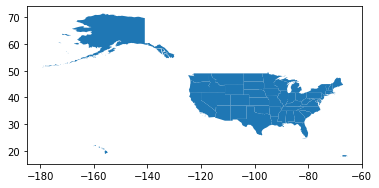

In [8]:
map_df.plot()
plt.xlim(-185,-60)

In [9]:
# I think we need the column info to match so I'm going by state

train['state'] = train['state'].str.upper()
train['state']

422539    OR
91660     CA
60604     AK
485540    TX
425631    OR
          ..
189268    FL
216088    IL
389925    ND
405563    OH
176928    FL
Name: state, Length: 377269, dtype: object

In [10]:
# And I think the value counts is what I will want to have to map

train['state'].value_counts()

CA    38558
FL    27353
TX    22016
NY    16707
MI    16037
OH    14526
OR    13127
NC    12583
PA    12069
WI    11713
WA    11239
TN    10565
CO     9739
IL     8770
VA     8621
IA     8485
NJ     7742
MN     7597
ID     7552
MA     7490
AZ     6583
AL     6547
MT     6359
SC     6235
IN     5781
KS     5414
CT     5172
GA     5146
AR     4912
MO     4863
OK     4749
KY     4662
MD     3373
NM     3096
AK     2989
LA     2879
NV     2358
RI     2340
VT     2326
NH     2290
ME     2231
HI     2154
DC     2048
NE     2045
MS     1903
SD     1814
UT     1272
DE     1093
WY      847
WV      692
ND      607
Name: state, dtype: int64

In [11]:
states_df = train['state'].value_counts().rename_axis('state').reset_index(name='ads')
states_df

,state,ads
0,CA,38558
1,FL,27353
2,TX,22016
3,NY,16707
4,MI,16037
5,OH,14526
6,OR,13127
7,NC,12583
8,PA,12069
9,WI,11713


In [12]:
# merge geopanda with dataset on state

merged = map_df.set_index('STUSPS').join(states_df.set_index('state'))

merged.head()

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,ads
STUSPS,,,,,,,,,,
MD,24,01714934,0400000US24,24,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",3373.0
IA,19,01779785,0400000US19,19,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",8485.0
DE,10,01779781,0400000US10,10,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",1093.0
OH,39,01085497,0400000US39,39,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",14526.0
PA,42,01779798,0400000US42,42,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",12069.0


In [13]:
merged.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'ads'],
      dtype='object')

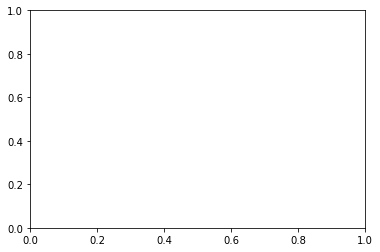

In [14]:
# prep for matplotlib
# set a variable of interest to plot

variable = 'ads'

# set ranges

vmin, vmax = 630, 39000

# fig xis size

fig, ax = plt.subplots(1,1)

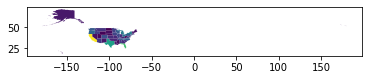

In [15]:
# create map
merged.plot(column = variable)


In [16]:
# Formatting
ax.set_title('Craigslist Ads by State', fontdict={'fontsize': '25', 'fontweight' : '3'})

ax.annotate('Scraped in January 2020',xy=(0.1,0.08), horizontalalignment='left')

# create legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin, vmax))

#empty array for data range

sm._A = []
cbar = fig.colorbar(sm)

In [26]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, optional, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (`sharex`) or y (`sharey`)
        axes:
    
            - True or 'all': x- or y-axis will be shared among all
              subplots.
            - False or 'none': each subplot x- or y-axis will be
              independent.
            - 'row': each subplot row will share an x- or y-axis.
            - 'col': each subplot column will share an x- or y-axis.
    
        Wh

Text(0.5, 1, 'Number of Craigslist Ads by State')

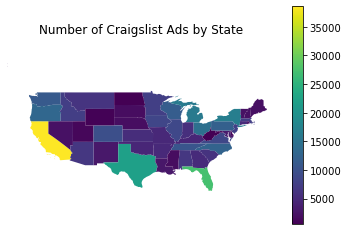

In [45]:

ax = merged.plot(column = variable, legend= True,  linewidth = 0.8)
ax.set_xlim(-130,-65)
ax.set_ylim(25,62)
ax.axis('off')
ax.set_title('Number of Craigslist Ads by State')

In [18]:
# Well screw that let's try plotly

# fig = px.choropleth(merged, geojson=counties, locations='fips', color='unemp',
#                            color_continuous_scale="Viridis",
#                            range_color=(0, 12),
#                            scope="usa",
#                            labels={'unemp':'unemployment rate'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

# okay never mind the .shp isn't made to play easily, but it would be cool later